In [9]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import json


In [8]:
data = pd.read_csv("../../data/datos_leb.csv")

In [10]:
def parse_embedding(x):
    return np.array(json.loads(x)) if isinstance(x, str) else np.array(x)

data['embedding'] = data['embedding'].apply(parse_embedding)

In [11]:
X = np.vstack(data['embedding'].values)


In [20]:
K = range(2, 19)

inertia_list = []
sil_list = []

for k in tqdm(K):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X)
    inertia_list.append(km.inertia_)
    sil_list.append(silhouette_score(X, labels))


  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:01<00:00, 16.49it/s]


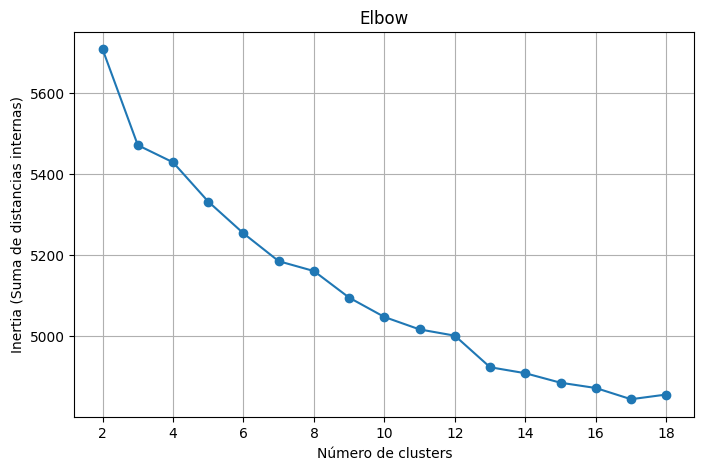

In [40]:
plt.figure(figsize=(8,5))
plt.plot(K, inertia_list, marker='o')
plt.title("Elbow")
plt.xlabel("Número de clusters")
plt.ylabel("Inertia (Suma de distancias internas)")
plt.grid(True)
plt.show()


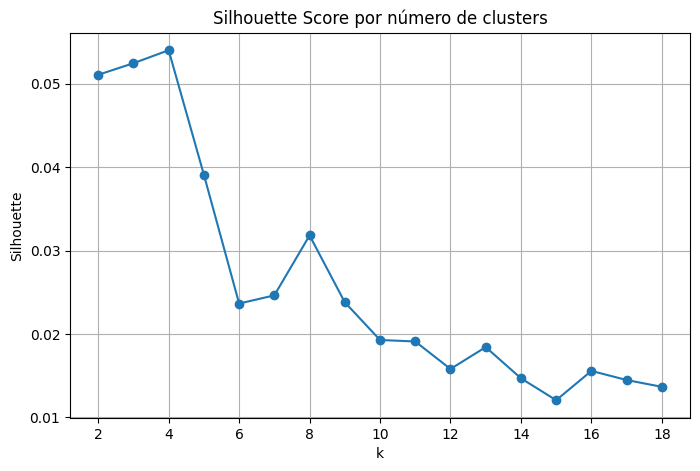

In [22]:
plt.figure(figsize=(8,5))
plt.plot(K, sil_list, marker='o')
plt.title("Silhouette Score por número de clusters")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)
plt.show()


In [23]:
best_k = K[np.argmax(sil_list)]
best_k


4

In [34]:
kmeans = KMeans(n_clusters=15, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X)

data['cluster'] = labels


In [35]:
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter

nltk.download("stopwords")

stop_en = set(stopwords.words("english"))
stop_es = set(stopwords.words("spanish"))
stop = stop_en | stop_es

custom_stop = {
    "the","and","of","to","in","is","it","i","was","for","my","we","you","me",
    "they","our","very","really","one","great","good","nice","amazing"
}

stop |= custom_stop


[nltk_data] Downloading package stopwords to /home/bita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-záéíóúñ ]", " ", text)
    tokens = [w for w in text.split() if w not in stop and len(w) > 2]
    return tokens

data["tokens"] = data["text"].apply(preprocess)


In [37]:
from math import log

cluster_docs = {c: [] for c in data.cluster.unique()}

for c, tokens in data.groupby("cluster")["tokens"]:
    cluster_docs[c] = [t for doc in tokens for t in doc]

# Document Frequency: en cuántos clusters aparece cada palabra
all_words = set(word for c in cluster_docs for word in cluster_docs[c])
df = {word: sum(word in cluster_docs[c] for c in cluster_docs) for word in all_words}

representative_words = {}

for c in cluster_docs:
    word_counts = Counter(cluster_docs[c])
    total_words = len(cluster_docs[c])

    tfidf = {}
    for word, tf in word_counts.items():
        tf = tf / total_words
        idf = log((1 + len(cluster_docs)) / (1 + df[word])) + 1
        tfidf[word] = tf * idf

    # Top 10 palabras representativas
    representative_words[c] = [
        w for w, score in sorted(tfidf.items(), key=lambda x: -x[1])[:10]
    ]



In [38]:
representative_words


{14: ['food',
  'place',
  'service',
  'like',
  'dish',
  'restaurant',
  'experience',
  'came',
  'bit',
  'water'],
 1: ['coffee',
  'cafe',
  'place',
  'service',
  'buenos',
  'aires',
  'delicious',
  'tango',
  'staff',
  'atmosphere'],
 2: ['food',
  'service',
  'place',
  'like',
  'back',
  'steak',
  'also',
  'beer',
  'best',
  'experience'],
 12: ['food',
  'service',
  'excellent',
  'delicious',
  'definitely',
  'restaurant',
  'waiter',
  'highly',
  'back',
  'friendly'],
 9: ['drinks',
  'bar',
  'place',
  'food',
  'music',
  'service',
  'cocktails',
  'atmosphere',
  'cocktail',
  'excellent'],
 11: ['bar',
  'cocktails',
  'best',
  'buenos',
  'aires',
  'drinks',
  'cocktail',
  'rooftop',
  'experience',
  'barman'],
 13: ['bar',
  'beer',
  'drinks',
  'place',
  'cocktails',
  'service',
  'like',
  'back',
  'cocktail',
  'food'],
 0: ['beer',
  'beers',
  'place',
  'hour',
  'service',
  'happy',
  'atmosphere',
  'food',
  'outside',
  'people'],
 

In [39]:
data["topic"] = data["cluster"].apply(
    lambda c: f"Topic {c}: " + ", ".join(representative_words[c][:4])
)


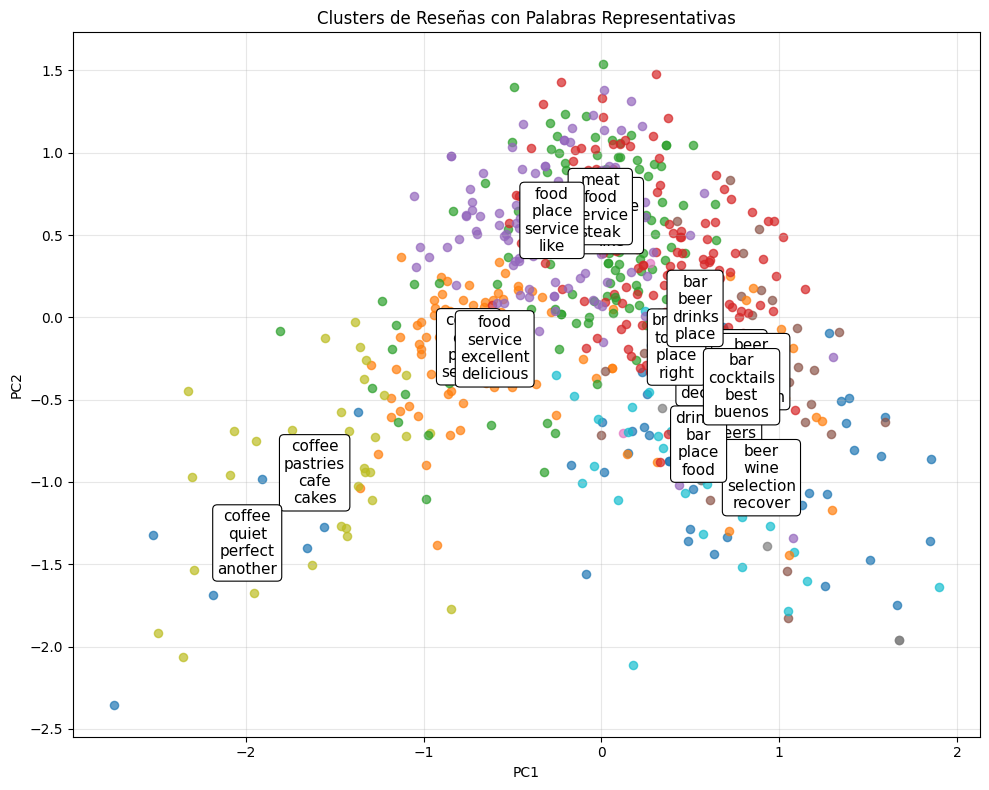

In [41]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming `data` exists with columns: 'embedding', 'cluster'
import numpy as np
import pandas as pd

# PCA
X = np.vstack(data['embedding'])
pca = PCA(n_components=2)
coords = pca.fit_transform(X)
data['pca_x'] = coords[:,0]
data['pca_y'] = coords[:,1]

# representative_words assumed computed
# Scatter plot
plt.figure(figsize=(10,8))
for c in sorted(data['cluster'].unique()):
    subset = data[data.cluster == c]
    plt.scatter(subset.pca_x, subset.pca_y, s=35, alpha=0.7, label=f"Cluster {c}")

# Add keywords text near centroids
for c in sorted(data['cluster'].unique()):
    subset = data[data.cluster == c]
    cx, cy = subset.pca_x.mean(), subset.pca_y.mean()
    words = representative_words[c][:4]
    plt.text(cx, cy, "\n".join(words), fontsize=11, ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.8))

plt.title("Clusters de Reseñas con Palabras Representativas")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




## 1. Arquitectura General de la App



In [ ]:
Datos crudos (Google Maps)
    ↓
Scraping + Preprocesamiento
    ↓
Embeddings (SentenceTransformer)
    ↓
Clustering (KMeans) → Tópicos
    ↓
Búsqueda semántica + Ranking
    ↓
Resultados al usuario



---

## 2. Generación de Embeddings: La Base de Todo

### 2.1 ¿Qué es un Embedding?

Un embedding es una **representación vectorial denso** de un texto. En lugar de trabajar con palabras como strings, convertimos el texto a un vector numérico de 384 dimensiones (en nuestro caso).

**Ejemplo conceptual:**


In [ ]:
Texto: "café tranquilo para trabajar con wifi"
         ↓ SentenceTransformer
Vector: [-0.0234, 0.456, -0.123, ..., 0.789]  (384 valores)



### 2.2 El Modelo: `paraphrase-MiniLM-L3-v2`


- **Basado en BERT destilado** (versión ligera de BERT, no la versión completa)
- **Multilingüe** (entiende español, inglés, etc.)
- **Entrenado en parafraseo**: significa que aprende a dar embeddings similares a textos que tienen significados parecidos, aunque usen palabras distintas
- **384 dimensiones** (vs BERT full con 768)
- **Tamaño**: ~33 MB (liviano para CPU)

**¿Por qué funciona?**
El modelo fue entrenado con millones de pares de textos parecidos. Durante el entrenamiento, aprendió a:
- Acercar (en el espacio vectorial) oraciones con significados similares
- Alejar oraciones con significados distintos
- Capturar conceptos semánticos (no solo palabras exactas)

**Ejemplo de lo que aprende:**


In [ ]:
"café tranquilo para trabajar"     → embedding_A
"lugar silencioso con wifi"        → embedding_B  (similar a embedding_A)
"bar ruidoso con banda en vivo"    → embedding_C  (distinto)

distancia(embedding_A, embedding_B) < distancia(embedding_A, embedding_C)



### 2.3 Proceso en Tu App (`precompute_embeddings`)



In [ ]:
def precompute_embeddings(db: Session) -> bool:
    model = get_model()  # Carga SentenceTransformer una sola vez (singleton)
    reviews = db.query(Review).filter(Review.embedding.is_(None)).all()  # Reviews sin embedding
    
    for batch in process_in_batches(reviews, BATCH_SIZE=8):
        texts = [preprocess_review(r.text, r.name) for r in batch]
        # batch = ["café tranquilo para trabajar", "lugar silencioso con wifi", ...]
        
        embeddings = model.encode(texts)  # Genera 384-dim vector por texto
        # embeddings.shape = (8, 384) si batch size es 8
        
        for review, embedding in zip(batch, embeddings):
            review.embedding = json.dumps(embedding.tolist())  # Guarda como JSON
        db.commit()



**¿Por qué batches?**
- Eficiencia: procesar 8 textos juntos es más rápido que uno a uno
- Memoria: 8 × 384 floats = ~12 KB; 1000 × 384 = ~1.5 MB (podría saturar RAM)

---

## 3. Clustering: KMeans
### 3.1 KMeans en `run_topic_modeling`



In [ ]:
def run_topic_modeling(db: Session, n_topics: int = 15) -> bool:
    embeddings = np.array([json.loads(r.embedding) for r in reviews])
    # embeddings.shape = (629, 384)  [629 reviews, cada una 384-dim]
    
    kmeans = KMeans(n_clusters=15, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(embeddings)
    # labels = [0, 4, 7, 0, 2, ..., 9]  [cada review asignada a cluster 0-14]



**¿Qué hace KMeans?**

1. **Inicializa 15 centroides** (puntos centrales en el espacio 384-D)
2. **Itera:**
   - Asigna cada embedding al centroide más cercano
   - Recalcula cada centroide como el promedio de los embeddings asignados
   - Repite hasta que converge (o max_iter=300)
3. **Resultado:** 15 clusters (grupos) de embeddings similares

**Visualización conceptual (simplificada a 2D):**


In [ ]:
                 Cluster 1 (Cafés)
                      ◯
                    ◯   ◯
                   ◯     ◯
        Cluster 0 ◯
        (Bares)    ◯
                    ◯
                      ◯        Cluster 2 (Restaurantes)
                                   ◯
                                 ◯   ◯



### 3.2 Extracción de Palabras Representativas (TF-IDF Manual)

Una vez que tienes los 15 clusters, tu app extrae palabras que mejor representen cada cluster:



In [ ]:
for review, label in zip(batch, batch_labels):
    texts_in_cluster = ' '.join(cluster_texts[label])  # Todos los textos del cluster
    words = texts_in_cluster.split()
    
    word_freq = {}
    for word in set(words):
        tf = words.count(word)  # Frecuencia en este cluster
        other_clusters_with_word = sum(1 for i in range(n_topics) 
                                       if i != label and word in cluster_texts[i])
        significance = tf / (1 + other_clusters_with_word)  # TF-IDF simplificado
        word_freq[word] = significance
    
    significant_words = sorted(word_freq.items(), key=lambda x: -x[1])[:4]
    review.topic = f"Topic {label}: {', '.join([w for w, _ in significant_words])}"



**Resultado:** Cada review etiquetado con su tópico:


In [ ]:
review.id = 345
review.topic = "Topic 4: café, tranquilo, wifi, trabajo"

review.id = 472
review.topic = "Topic 7: música, banda, show, vivo"



---

## 4. ¿Cómo Busca el Usuario? (La Pregunta Clave)

### 4.1 Flujo de Búsqueda en `find_similar_to_query`

Cuando el usuario escribe "café tranquilo para trabajar", **la app NO usa tópicos para buscar**. Los tópicos son solo metadata descriptiva. La búsqueda es **puramente semántica por similitud coseno**:



In [ ]:
def find_similar_to_query(db: Session, query: str, min_rating: float = 0.0):
    # 1. Convertir consulta del usuario a embedding (384-dim)
    query_embedding = model.encode(preprocess_review(query))
    # query = "café tranquilo para trabajar"
    # query_embedding = [-0.0234, 0.456, -0.123, ..., 0.789]  (384 valores)
    
    # 2. Obtener TODOS los reviews con embeddings
    reviews = db.query(Review).filter(Review.embedding.isnot(None)).all()
    # 629 reviews
    
    # 3. Calcular similitud coseno contra todos
    batch_embeddings = np.array([json.loads(r.embedding) for r in reviews])
    # batch_embeddings.shape = (629, 384)
    
    similarities = cosine_similarity([query_embedding], batch_embeddings)[0]
    # similarities = [0.51, 0.48, 0.32, 0.89, ...]  (629 valores, entre 0 y 1)
    
    # 4. Filtrar por threshold y combinar con rating
    results = []
    for review, similarity in zip(reviews, similarities):
        if similarity > SIMILARITY_THRESHOLD (0.2):  # Solo si es suficientemente parecido
            rating = float(review.rating) / 5.0  # Normalizar rating a [0, 1]
            combined_score = 0.7 * similarity + 0.3 * rating_norm
            results.append({
                "place_id": review.place_id,
                "name": review.name,
                "similarity_score": similarity,
                "topic": review.topic,  # Incluye tópico como info adicional
                "score": combined_score
            })
    
    # 5. Ordenar por score combinado
    results.sort(key=lambda x: x["score"], reverse=True)
    return results[:20]  # Top 20



### 4.2 Similitud Coseno: La Métrica

La **similitud coseno** mide el ángulo entre dos vectores:



In [ ]:
similitud_coseno(A, B) = (A · B) / (||A|| × ||B||)

Resultado: número entre 0 (totalmente distinto) y 1 (idéntico)



**Ejemplo con 2 dimensiones (simplificado):**


In [ ]:
query_embedding = [0.8, 0.6]
review_1_embedding = [0.9, 0.5]  → similitud ≈ 0.98 (muy parecido)
review_2_embedding = [-0.7, 0.3] → similitud ≈ -0.21 (muy distinto)



### 4.3 ¿Dónde Entran los Tópicos?

**Los tópicos NO afectan la búsqueda, solo la visualización:**

1. **Búsqueda:** Similitud coseno pura (sin tópicos)
2. **Resultados:** Cada resultado incluye su tópico como metadata descriptiva

Si la consulta es "café tranquilo", podrías obtener:


In [ ]:
1. "Tónico Café" 
   - similarity_score: 0.85
   - topic: "Topic 4: café, tranquilo, wifi, trabajo"
   
2. "Bicho Café de Especialidad"
   - similarity_score: 0.82
   - topic: "Topic 4: café, tranquilo, wifi, trabajo"
   
3. "Bar la Juguetería" (lugar tranquilo, pero no café)
   - similarity_score: 0.61
   - topic: "Topic 7: música, ambiente, tranquilo, relax"



Los tópicos ayudan al usuario a entender por qué esos lugares fueron devueltos, pero no filtran la búsqueda.

---

## 5. Diagrama de Flujo Completo



In [ ]:
┌─────────────────────────────────────────────────────────────┐
│ FASE 1: PREPARACIÓN (Una sola vez)                          │
├─────────────────────────────────────────────────────────────┤
│ 1. Scraping: Google Maps → Base de datos (629 reviews)      │
│ 2. Preprocesamiento: limpieza, tokenización                 │
│ 3. Embedding: SentenceTransformer → 384-dim vectors         │
│ 4. Clustering: KMeans (15 clusters) → Tópicos              │
│    - Cada review tiene: embedding + tópico + metadata       │
└─────────────────────────────────────────────────────────────┘
                            ↓
┌─────────────────────────────────────────────────────────────┐
│ FASE 2: BÚSQUEDA EN TIEMPO REAL (Cada consulta del usuario) │
├─────────────────────────────────────────────────────────────┤
│ 1. Usuario escribe: "café tranquilo para trabajar"          │
│ 2. Query embedding: SentenceTransformer → 384-dim           │
│ 3. Similitud coseno: Query vs 629 embeddings guardados      │
│ 4. Filtrar por threshold (> 0.2)                            │
│ 5. Combinar con rating: 0.7*similitud + 0.3*rating         │
│ 6. Ordenar y devolver top 20                                │
│ 7. Incluir tópico en respuesta (metadata)                   │
└─────────────────────────────────────────────────────────────┘



---

## 6. Ventajas de Este Enfoque

1. **Semántica vs Keywords:** Entiende "lugar silencioso" como similar a "café tranquilo", aunque no comparten palabras exactas
2. **Escalable:** Similitud coseno es O(n) — rápido incluso con 1000+ reviews
3. **Flexible:** No depende de categorías predefinidas (tópicos emergen de los datos)
4. **Rating-aware:** Combina similitud semántica con calidad (rating)
5. **Tópicos informativos:** Ayudan a entender clusters temáticos, pero no "encierra" la búsqueda

---
